Using machine learning based methods to identify defaults in matter during laser powder processes

#### Prior python installs (Tip : Don't forget to generate a virtual environment so as not to clutter your python workspaces)

!pip install soundfile \
!pip install sounddevice\
!pip install scipy 



In [4]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.fftpack


import wave
import struct
import sys
import csv

from scipy.io import wavfile
from scipy.signal import resample

import sounddevice as sd
import soundfile as sf

import os

from IPython import display
from IPython.display import Audio

#import tensorflow for yamnet
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio


data_folder = './data/'
wav_folder_rx ='./samples_A_RX1_C0/'
wav_folder_deformed ='./samples_A_DEFORMED1_C0/'

In [2]:
#CSV filenames
deformed01 = 'A_DEFORMED1_C0'
deformed02 = 'A_DEFORMED1_C0'
rx01 = 'A_RX1_C0'

#WAV filenames
wav_rx = 'sample_A_RX1_C00'



In [4]:
df = pd.read_csv(data_folder + file + '.csv', header = None)

In [5]:
df.shape

(32000000, 1)

In [6]:

#initialisation of clock variables
clock = 3048780.48780488
delay_in_samples = 304878
g_T = 1 / clock
g_N = len(df)

print("the frequency of the signal is", clock * 1e-6, "MHz")
print("the total duration of the signal is", g_N / clock, "seconds")
print("number of samples :", len(df))


the frequency of the signal is 3.04878048780488 MHz
the total duration of the signal is 10.495999999999993 seconds
number of samples : 32000000


In [7]:
#create a second array containing the timestamps of my dataset: 
def prepareData(df,T):
    df['time'] = np.arange(len(df)) * T
    df.rename(columns = {0:'amplitude'}, inplace = True)
    return df 

conduction = prepareData(df.copy(), g_T)

In [8]:
conduction.head(5)

,amplitude,time
0,0.005493,0.000000e+00
1,0.002136,3.280000e-07
2,0.007019,6.560000e-07
3,0.005798,9.840000e-07
4,0.006104,1.312000e-06


In [9]:
#small snapshot to visualize the signal


#THERE IS A MAJOR ISSUE BECAUSE I DID NOT DEFINE TIME AS AN ORDERED INDEX. SO WHEN I EXTRACT THE SIGNAL IM ITERATING OVER 
#A SHIT TON OF VALUES (THE FULL SIZE OF THE SIGNAL) INSTEAD OF SIMPLY GOING ON THE RANGE OF THE INDEX
def extract_signal(signal, startTime, endTime):
    smaller_signal = conduction[conduction['time'].apply(lambda x: (x > startTime) & (x < endTime))]
    small_T = g_T
    small_N = len(smaller_signal)
    return smaller_signal, small_N, small_T
    

def showFFT(signal, N, T):
    amplitudes = signal['amplitude'].to_numpy()
    x = np.linspace(0.0, N*T, N, endpoint=False)
    y = amplitudes
    yf = scipy.fftpack.fft(amplitudes)
    xf = scipy.fftpack.fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    plt.show()
    print("Fourier transform of the signal")
    
def plot_signal(signal):
    signal.plot(x='time', y='amplitude')  

In [10]:
sample_signal, sample_N, sample_T = extract_signal(conduction,2e-4,3e-4)


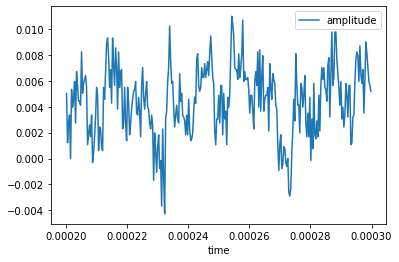

In [11]:
plot_signal(sample_signal)

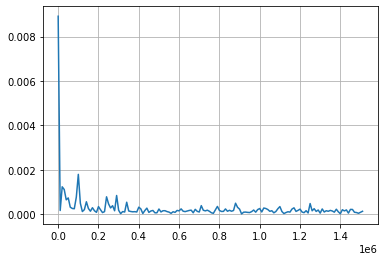

Fourier transform of the signal


In [12]:
showFFT(sample_signal, sample_N, sample_T)

In [41]:
#remove the last points so that the array length is divisible by the number of points per sample 
#in order to have equal lengths sample
def clean_data(df):
    epsilon =  1e-1
    #remove the silence at the end: 
    for i in range(len(df) - 1, 0, -1):
        if(df[0][i] > epsilon):
            print("deleted", (len(df) - i) / clock, "samples from the end because we assume it is silence from", len(df) / clock, "samples")
            return df[:i]

def split_csv(filename, T):
    df = pd.read_csv(data_folder + filename + '.csv', header = None)
    df = clean_data(df)
    df.rename(columns = {0:'amplitude'}, inplace = True)
    point_per_sample = int(160e-3 * clock)
    
    nb_of_samples = int(len(df)/point_per_sample)
    data = df[:nb_of_samples * point_per_sample]
    return np.array_split(data, nb_of_samples)

data_deformed = split_csv(deformed01, g_T)
data_rx = split_csv(rx01, g_T)




deleted 1.3556525359999991 samples from the end because we assume it is silence from 10.495999999999993 samples
deleted 1.3556525359999991 samples from the end because we assume it is silence from 10.495999999999993 samples
deleted 1.2826049679999991 samples from the end because we assume it is silence from 10.495999999999993 samples


In [81]:


#Transforming the data into a .wav file
from scipy.io.wavfile import write
samplerate = 16000#int(clock) sample à 16khz
file = "sample_A_DEFORMED1_C0"
#convert the data into a 16 bit integer amplitude signal => change scale
max_amplitude = np.max(np.abs(conduction['amplitude']))
max_int16 = np.iinfo(np.int16).max
#data = (conduction['amplitude'] * (max_int16/max_amplitude)).astype(np.int16)
for index in range(len(samples)):
    sample = (samples[index] * (max_int16/max_amplitude)).astype(np.int16)
    write(file + str(index) + '.wav', samplerate, sample)





In [20]:
#reading the data and listening to it because why not!
#it's cool to listen to something you're just seeing as numbers!
sd.play(conduction, 1e5)
status = sd.wait()

KeyboardInterrupt: 

### Idea 1 : using an SVM to separate the data
Do PCA on the data \
Apply SVM on the data \

### Idea 2 : using a neural network to separate the data
WPT (Wavelet package transform) \
Design a CNN (Convolutional Neural Network) \



In [37]:
16*1e3 / (3*1e6)

0.005247999999999997

In [38]:
1/0.005333333333333333

190.548780487805

#YAMNET PART

In [16]:
#load the yamnet model
model = hub.load('https://tfhub.dev/google/yamnet/1')

In [7]:
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = scipy.signal.resample(waveform, desired_length)
  return desired_sample_rate, waveform

### Loading the class types

In [22]:
# Find the name of the class with the top score when mean-aggregated across frames.
def class_names_from_csv(class_map_csv_text):
  """Returns list of class names corresponding to score vector."""
  class_names = []
  with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      class_names.append(row['display_name'])

  return class_names

class_map_path = model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)
print(class_names)

['Speech', 'Child speech, kid speaking', 'Conversation', 'Narration, monologue', 'Babbling', 'Speech synthesizer', 'Shout', 'Bellow', 'Whoop', 'Yell', 'Children shouting', 'Screaming', 'Whispering', 'Laughter', 'Baby laughter', 'Giggle', 'Snicker', 'Belly laugh', 'Chuckle, chortle', 'Crying, sobbing', 'Baby cry, infant cry', 'Whimper', 'Wail, moan', 'Sigh', 'Singing', 'Choir', 'Yodeling', 'Chant', 'Mantra', 'Child singing', 'Synthetic singing', 'Rapping', 'Humming', 'Groan', 'Grunt', 'Whistling', 'Breathing', 'Wheeze', 'Snoring', 'Gasp', 'Pant', 'Snort', 'Cough', 'Throat clearing', 'Sneeze', 'Sniff', 'Run', 'Shuffle', 'Walk, footsteps', 'Chewing, mastication', 'Biting', 'Gargling', 'Stomach rumble', 'Burping, eructation', 'Hiccup', 'Fart', 'Hands', 'Finger snapping', 'Clapping', 'Heart sounds, heartbeat', 'Heart murmur', 'Cheering', 'Applause', 'Chatter', 'Crowd', 'Hubbub, speech noise, speech babble', 'Children playing', 'Animal', 'Domestic animals, pets', 'Dog', 'Bark', 'Yip', 'Howl'

Sample rate: 16000 Hz
Total duration: 30.49s
Size of the input: 487804


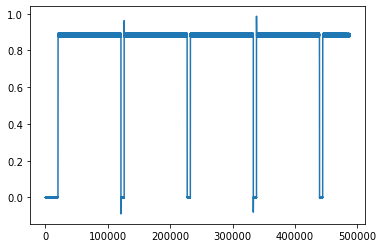

In [28]:
#load a .wav file
def load_wav_file(filename):
    sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')

    #basic information from the extracted signal
    duration = len(wav_data)/sample_rate
    print(f'Sample rate: {sample_rate} Hz')
    print(f'Total duration: {duration:.2f}s')
    print(f'Size of the input: {len(wav_data)}')



    #normalise the data
    waveform = wav_data / tf.int16.max
    return waveform

    
    
wav_file_name = wav_folder_rx + wav_rx + '.wav'
wavefile = load_wav_file(wav_file_name)

_ = plt.plot(wavefile)



In [ ]:
print("Audio of the laser")
print(Audio(wav_data, rate=sample_rate))

In [17]:
scores, embeddings, spectrogram = model(waveform)

In [21]:
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: Mains hum


### some data visualisation 

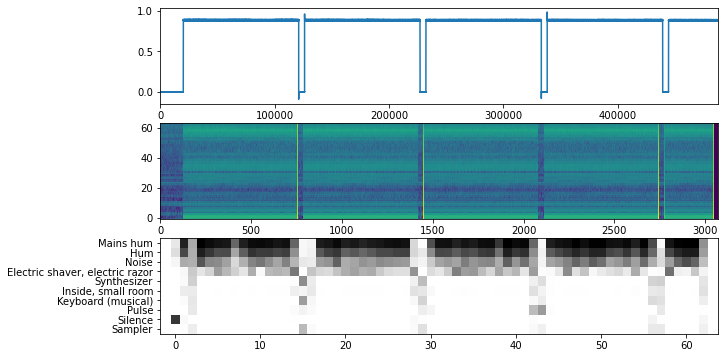

In [27]:
def view_sample_result(waveform):
    plt.figure(figsize=(10, 6))

    # Plot the waveform.
    plt.subplot(3, 1, 1)
    plt.plot(waveform)
    plt.xlim([0, len(waveform)])

    # Plot the log-mel spectrogram (returned by the model).
    plt.subplot(3, 1, 2)
    plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

    # Plot and label the model output scores for the top-scoring classes.
    mean_scores = np.mean(scores, axis=0)
    top_n = 10
    top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
    plt.subplot(3, 1, 3)
    plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

    # patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
    # values from the model documentation
    patch_padding = (0.025 / 2) / 0.01
    plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
    # Label the top_N classes.
    yticks = range(0, top_n, 1)
    plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
    _ = plt.ylim(-0.5 + np.array([top_n, 0]))

view_sample_result(waveform)

In [48]:
my_classes = ['deformed', 'rx']
map_class_to_id = {'deformed':0, 'rx':1}
